# Lecture 4: Time Series Analysis

Time series analysis is a very useful tool in financial engineering, especially when trying to extract a trend out of a stochastic process, calculate a smooth series (such as those "indicators" eg. SMA, EMA, etc), and forecast future developements of a time series. This notebook should hopefully cover all of these tasks and beyond. 

The main topics of discussion are:

 1. Introduction to TSA
 2. Characteristics of time series
 3. Selected time series models
 4. Model Diagnostics
 5. Volatility Forecasting
 



In [1]:
#Importing standard libraries


import numpy as np
from matplotlib import pyplot as plt 
import scipy as sci
import pandas as pd

## Introduction to Time Series Analysis

A time series $(Y_t)_{t \geq 0} = (\dots,Y_{-2},Y_{-1},Y_0,Y_1,Y_2, \dots)$ is defined as a realization of a stochastic process at equidistantly spaced points in time. A univariate time series can be described by a sequence $(y_1,y_2,\dots,y_T)$ or in short $(y_t)^T_{t = 1}$. The random variable $Y_t$ is assumed to be metric and the process is assumed to be stationary (invariant under a time transformation $t \rightarrow t+h$, where $h$ is a lag).

By looking at, say, the SP500 index chart in a multi-decade long timeframe, one can see that there are trends, cycles, seasonalities, etc. This is why it makes sense to use TSA to study financial data. One can then study the volatilities in various seasons, etc.


The standard models of a time series assume additive components such as trends, cycles, seasonalities, etc as well as a stochastic component. The simplest trend model one could think of is the following:

$$y_t = d_t + u_t$$

where $d_t$ is some deterministic trend and $u_t$ being a stochastic stationary factor (usually assumed to be _white noise_, or $u_t \sim N(0,\sigma^2)$)


#### Python Implementation

Say we have a linear trend $d_t = x$ and gaussian noise as a stochastic factor $u_t \sim N(0,1)$. We could then model the time series $y_t$ as follows:

In [2]:
T = range(0,40) #time

d_t = T #trend 

y_t = [i + np.random.normal(0,1) for i in T] #time series


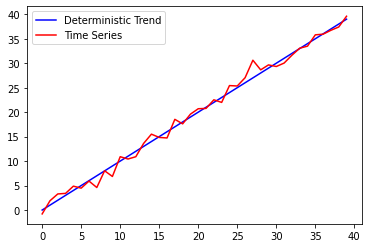

In [3]:
plt.plot(T,d_t,color='blue',label='Deterministic Trend')
plt.plot(T,y_t,color='red',label='Time Series')
plt.legend()

The example above is likely the simplest possible model, although one can make it additive by adding seasonal factors and cycles (think, sine function for example). The result will be 

$$y_t = d_t + s_t + u_t$$

where $s_t$ represent a seasonal component. 


As mentioned informally in the very top of this notebook, a typical goal in TSA is to extract $d_t$ and $s_t$ out of $y_t$. This could be achieved by

 1. Calculating the estimates $\hat{d_t}$ and $\hat{s_t}$
 2. Calculating the time series of the residuals as $\hat{u_t} = y_t - \hat{d_t} -\hat{s_t}$
 
If $\hat{u_t}$ then satisfies assumptions (i.e $\hat{u_t} \sim WN(\mu,\sigma^2)$), then the estimates are accurate. If it is not accurate, then there is likely some error in $\hat{d_t}$ and/or $\hat{s_t}$.


Another way to "detrend the model" is to apply what is known as the _lag operator_ $\tilde{y_t}$. For a linear trend (such as the example above), the lag operator should simply be

$$\tilde{y_t} = y_t - y_{t - 1}$$


#### Python Implementation 

Say 

$$y_1 = t + s_t$$

and 

$$y_2 = (t + 1) + s_t$$

Let us try to apply a lag operator

Mu = 0.9451753036872349, Sigma^2 = 1.9684911769634423


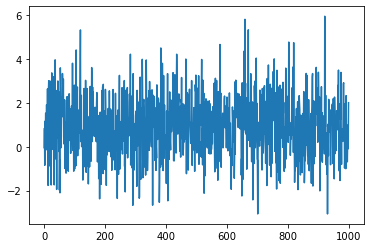

In [4]:
T = range(0,1000) #time



y_1 = np.array([i + np.random.normal(0,1) for i in T])
y_2 = np.array([i + 1 + np.random.normal(0,1) for i in T])


lag_op = y_2 - y_1 

plt.plot(T,lag_op)
print("Mu = "+str(np.mean(lag_op))+", Sigma^2 = "+str(np.std(lag_op)**2))

Let us now try compare the histogram data of `lag_op` to the normal distribution with the parameters given above (mu and sigma\*\*2), and then test for normality using the Jarque-Berat test with a standard 5\% tolerance. 

p-value: 0.7028754763922176 which is much higher than 0.05, rendering the test positive.


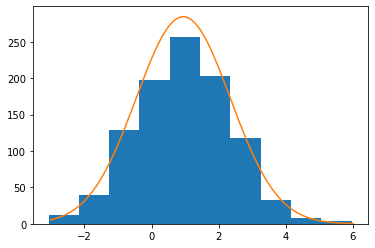

In [11]:
from scipy.stats import norm
plt.hist(lag_op)#histogram
plt.plot(np.linspace(-3,6,10000),[1000*norm.pdf(i,np.mean(lag_op), np.std(lag_op)) for i in np.linspace(-3,6,10000)])

JB_test = sci.stats.jarque_bera(lag_op)

print('p-value: '+str(JB_test.pvalue)+" which is much higher than 0.05, rendering the test positive.")




as you can see, it passes the normality test and fits the distribution, thus proving the lag operator $\tilde{y_2}$ produces white noise. 

To determine the trendline of a time series, one either employs _moving averages_ of order $q$, which takes the following form:

$$\hat{d_t} = \hat{\beta_1}y_{t - 1} + \hat{\beta_2}y_{t - 2} + \dots + \hat{\beta_q}y_{t - q} = \sum_{i = 1}^q \hat{\beta_i}y_{t - i}$$

or _polynomial fitting_ of order $q$, which takes the form

$$\hat{d_t} = \hat{\beta_0} + \hat{\beta_1}t + \hat{\beta_2}t^2 + \dots + \hat{\beta_q}t^q = \sum_{i = 0}^q \hat{\beta_i}t^i$$

#### Python Implementation

We will try to fit a polynomial model of order 5 to \$GOOG price data from 2016 to 2021.


In [35]:
from pandas_datareader import data ## This import allows us to import stock price data from yahoo finance

def get_stock_price(ticker, start='2016-01-01', end='2020-12-31',price_type = 'Adj Close'): ##function from lecture 1
    return data.DataReader(ticker,'yahoo',start,end)[price_type]

data = list(get_stock_price('GOOG')) #google price data as a list



In [48]:
q_eq_5 = lambda t,a,b,c,d,e,f: a + b*t + c*(t**2) + d*(t**3) + e*(t**4) + f*(t**5) #polynomial function where q=5

model = sci.optimize.curve_fit(q_eq_5_model,list(range(len(data))),data) #estimated beta values (params of best fit)

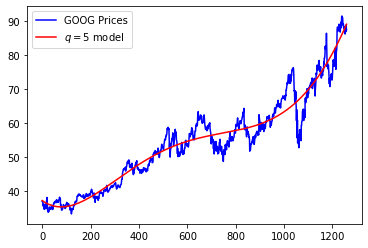

In [59]:
plt.plot(data,color='blue',label='GOOG Prices') #plotting stock data
plt.plot([q_eq_5_model(i,*model[0]) for i in range(len(data))],color='red',label=r'$q = 5$ model') #plotting the model
plt.legend()

As you can see, the model, whilst doesn't capture the noise, follows the trend of the data very well. Another useful thing to do would be plot the residuals in a histogram (which represents the probability distribution of the price being a value $\eta = y_t - \hat{y_t}$ away from the trendline).

(array([ 19.,  32., 110., 308., 436., 252.,  66.,  21.,   7.,   8.]),
 array([-10.88832358,  -8.38953926,  -5.89075495,  -3.39197063,
         -0.89318631,   1.605598  ,   4.10438232,   6.60316663,
          9.10195095,  11.60073526,  14.09951958]),
 <BarContainer object of 10 artists>)

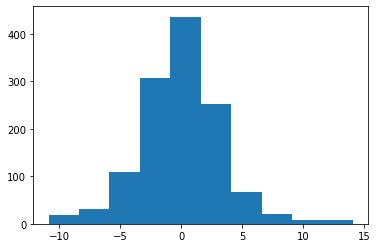

In [51]:
resid = np.array([q_eq_5_model(i,*model[0]) for i in range(len(data))]) - np.array(data) #eta values

plt.hist(resid)

Where one could refer to Lecture 2 to fit this data into an appropriate distribution. 

To learn to employ moving averages in python, one can watch [this video](https://www.youtube.com/watch?v=I6ZBJo_xt2I)!




## Characteristics of Time Series

A time series $Y_t$ can be characterized by a function of expectation values

$$\mu(t) = \mathbb{E}(Y_t)$$

a covarariance function

$$\gamma(t, t+k) = Cov(Y_t,Y_{t+k}) \\ = \mathbb{E}\left((Y_t - \mu_t)(Y_{t + k} - \mu_{t + k})\right)$$

and an autocorrelation function

$$\rho(t, t+k) = \frac{Cov(Y_t,Y_{t+k})}{\sqrt{Var(Y_t)\sqrt{Var(Y_{t+k})}}} \\ = \frac{\gamma(Y_t,Y_{t+k})}{\sqrt{\gamma(t,t)}\sqrt{\gamma(t+k,t+k)}}$$

as per the definitions laid out in Lecture 1.

#### Weak Stationary Time Series

A weakly stationary time series is any time series that has the following characteristics:

 1. $\mu(t) = \mu \in \mathbb{R}$
 2. $\gamma(t, t+k) = \mu(k)$
 3. $\rho(t, t+k) = \rho(k) = \frac{\gamma(k)}{\gamma(0)}$
 
 
 In other words, a time series with constant expected value and with covariance and autocorrelation functions that depends soley on the lag $k$.
 
 
**Example:**

Let us consider a time series such that

$$Y_0 = 0$$
and 
$$Y_{t+1} = Y_t + u_t$$

where $u_t \sim N(0,\sigma^2)$ is assumed to be white noise. Such a process is called a random walk, and our goal here is to find out whether they are a stationary time sreries.


First let us implement it in Python:

In [54]:
def random_walk(sigma=1,n=100):
    Y = np.zeros(n) #initializing the time series 
    Y[0] = 0 #making it explicit that Y_0 = 0
    
    for t in range(n-1):
        Y[t+1] = Y[t] + np.random.normal(0,sigma) #Y_t+1 depends on Y_t and some white noise
    return Y

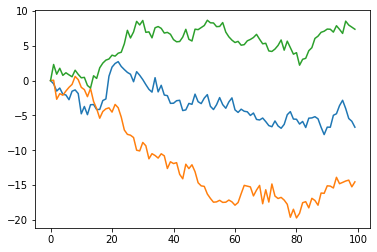

In [57]:
for i in range(3):
    plt.plot(random_walk())

A keen reader may realize such a process, as it is a general case of the result of the coin game in lecture 2! (The only difference being that we were constrained to -1 and 1 in the coin game).

Remember, a key condition for a time series to be weakly stationary is that $\gamma(t,t)$ depends only on the lag $k$. Let us see if that is the case:

$$Y_t = Y_{t - 1} + u_t \\ = (Y_{t - 2} + u_{t-1}) + u_t \\ = (Y_{t - 3} + u_{t-2}) + u_{t-1}) + u_t \\ = \dots \\ = Y_{0} + \sum_{i = 1}^t u_i$$


In other words, a random walk is $Y_t$ is nothing but its initial conditions $Y_0 = 0$ plus a set of $t$ normally distributed random numbers (white noise). With that, we can say


$$\gamma(t,t) = Var(Y_t) \\ = Var(Y_0 + \sum_{i = 1}^t u_i) \\ = Var(\sum_{i = 1}^t u_i)$$

which, according to [Bienaymé's Equation](https://stats.stackexchange.com/questions/31177/does-the-variance-of-a-sum-equal-the-sum-of-the-variances), gives

$$\gamma(t,t) = \sum_{i = 1}^t Var(u_i)$$

which, because $Var(u_i) = \sigma^2$, gives us

$$\gamma(t,t) = \sigma^2t$$

In other words, $\gamma(t,t)$ clearly depends on $t$ for the random walk, rendering it not weakly stationary. 